In [194]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# supernovae_lst = pd.read_csv("./TESS_data/sn_count_transients_s1-47 (4).txt")
transients = pd.read_csv("./TESS_data/AT_count_transients_s1-47 (4).txt", names=["sector", "ra", "dec", "mag", "TJD_discovery", "type" ,"class", "IAU", "survey", "cam", "ccd", "col", "row"], delim_whitespace=True)
transients

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
0,1,327.160083,-43.380019,17.800,1340.340,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643
1,1,315.033417,-40.358594,17.869,1341.926,SN,SNIa,2018exc,ATLAS,1,1,528.652,1304.728
2,1,313.474583,-38.015594,18.781,1347.901,SN,SNII,2018fgb,ATLAS,1,1,424.192,1751.547
3,1,332.648000,-27.250161,16.700,1331.630,SN,SNII,2018emt,ASAS-SN,1,3,642.568,1607.839
4,1,327.584333,-26.300131,19.405,1337.965,AT,Unclassified,2018esp,ATLAS,1,3,1303.439,1157.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,47,167.461817,75.334383,20.670,2601.001,AT,Unclassified,2022aji,Pan-STARRS1,3,2,521.417,1084.865
4399,47,210.216792,78.085778,19.680,2601.143,AT,Unclassified,2022aha,Pan-STARRS1,3,3,1679.425,1415.721
4400,47,300.459933,85.849581,18.075,2588.733,AT,Unclassified,2022gn,ATLAS,3,4,1667.608,986.600
4401,47,256.141083,76.155150,18.470,2589.662,AT,Unclassified,2022op,GaiaAlerts,4,1,1990.840,279.007


In [195]:
light_curves = os.listdir("./TESS_data/light_curves_fausnaugh")
# name = light_curves[random.randint(0, len(light_curves)-1)]
# print(light_curves[i])
filename = "lc_2018evo_cleaned"
curve = pd.read_csv("./TESS_data/light_curves_fausnaugh/" + filename, delim_whitespace=True)

#read AT_count file to find nonlight curve data of transient
curve_name = filename.split("_")[1]
curve_meta = transients[transients['IAU'] == curve_name]
display(curve_meta)

,sector,ra,dec,mag,TJD_discovery,type,class,IAU,survey,cam,ccd,col,row
0,1,327.160083,-43.380019,17.8,1340.34,SN,SNIa,2018evo,ASAS-SN,1,1,1860.105,322.643


In [196]:
curve['relative_time'] = curve['TJD'] - curve_meta["TJD_discovery"][0]
curve.index = pd.TimedeltaIndex(curve['relative_time'], unit="D")
plot_title = f"{curve_name}\n Class: {curve_meta['class'][0]}, Sector: {curve_meta['sector'][0]} \nCoords:{curve_meta['ra'][0], curve_meta['dec'][0]}, \nDiscovery TJD: {curve_meta['TJD_discovery'][0]}, Survey: {curve_meta['survey'][0]}"

def display_curve(col, error):
    return curve.plot.scatter(x="relative_time", y=col, c="00000", alpha=0.5, yerr=curve[error], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)

# Preprocessing steps
## 1. Sigma Clipping: remove points with flux uncertainties more than 3 sigma from mean uncertainty, repeat clipping 5 times

<AxesSubplot:title={'center':'2018evo\n Class: SNIa, Sector: 1 \nCoords:(327.16008333, -43.38001944), \nDiscovery TJD: 1340.34, Survey: ASAS-SN'}, xlabel='Days relative to discovery', ylabel='Flux'>

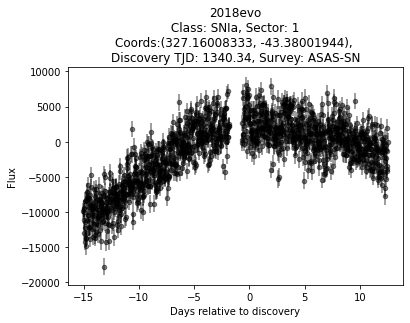

In [197]:

for _ in range(0, 5):
    uncert_mean = curve.e_cts.mean()
    threshold = 3*curve.e_cts.std()
    curve = curve[np.abs(curve['e_cts'] - uncert_mean) <= threshold]

display_curve("cts", "e_cts")

## 2. Subtract background Flux

<AxesSubplot:title={'center':'2018evo\n Class: SNIa, Sector: 1 \nCoords:(327.16008333, -43.38001944), \nDiscovery TJD: 1340.34, Survey: ASAS-SN'}, xlabel='Days relative to discovery', ylabel='Flux'>

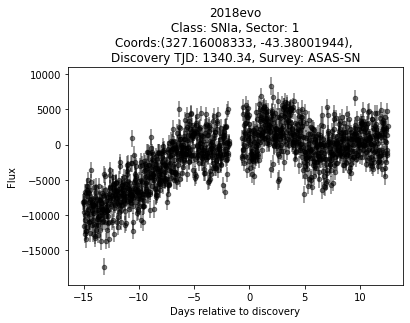

In [198]:
curve['no_bkg_cts'] = curve['cts'] - curve['bkg_model']
display_curve('no_bkg_cts', "e_cts")

## 3. Correct for milky way extinction using Fitzpatrick Reddening function
Wavelength of TESS bandpass is between 600-1000nm, central wavelength is 786.5nm

<AxesSubplot:title={'center':'2018evo\n Class: SNIa, Sector: 1 \nCoords:(327.16008333, -43.38001944), \nDiscovery TJD: 1340.34, Survey: ASAS-SN'}, xlabel='Days relative to discovery', ylabel='Flux'>

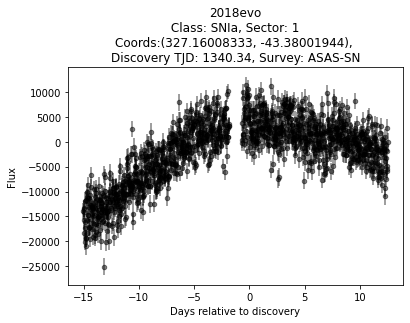

In [199]:
import extinction
from astroquery.irsa_dust import IrsaDust
import astropy.coordinates as coord
import astropy.units as u

# Set relevant parameters
ra = curve_meta["ra"][0]
dec = curve_meta["dec"][0]
flux_in = curve["cts"]
fluxerr_in = curve["e_cts"]
bandpass_wavelengths = np.array([786.5,])


# Get Milky Way E(B-V) Extinction
coo = coord.SkyCoord(ra * u.deg, dec * u.deg, frame='icrs')
dust = IrsaDust.get_query_table(coo, section='ebv')
mwebv = dust['ext SandF mean'][0]


# Remove extinction from light curves (Using negative a_v so that extinction.apply works in reverse and removes the extinction)
extinction_per_passband = extinction.fitzpatrick99(wave=bandpass_wavelengths, a_v=-3.1 * mwebv, r_v=3.1, unit='aa')
flux_out = extinction.apply(extinction_per_passband[0], flux_in, inplace=False)
fluxerr_out = extinction.apply(extinction_per_passband[0], fluxerr_in, inplace=False)

curve['unreddened_cts'] = flux_out
curve['unreddened_ects'] = fluxerr_out

display_curve('unreddened_cts', 'unreddened_ects')

## 4. Normalize Data

<AxesSubplot:title={'center':'2018evo\n Class: SNIa, Sector: 1 \nCoords:(327.16008333, -43.38001944), \nDiscovery TJD: 1340.34, Survey: ASAS-SN'}, xlabel='Days relative to discovery', ylabel='Flux'>

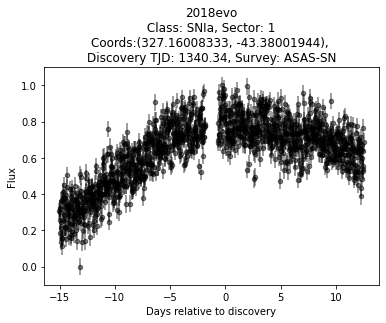

In [200]:
curve['normalized_cts'] = (curve.unreddened_cts - curve.unreddened_cts.min()) / (curve.unreddened_cts.max()-curve.unreddened_cts.min())
curve['normalized_ects'] = curve['unreddened_ects'] / (curve.unreddened_cts.max()-curve.unreddened_cts.min())
# curve.plot.scatter(x="BTJD", y='normalized_cts', c="00000", alpha=0.5, ylabel="Flux", xlabel="Barycentric TESS Julian Date")
display_curve('normalized_cts', 'normalized_ects')

In [201]:
#display all data
curve

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects,normalized_cts,normalized_ects
relative_time,,,,,,,,,,,,,,
-16 days +23:21:15.840000,1325.32856,1325.31310,-9780.1896,1135.3635,-2140.5920,-1588.9112,-1077.4884,1135.3635,-15.02690,-8191.2784,-13813.250930,1603.553874,0.309297,0.044056
-16 days +23:51:15.552000,1325.34939,1325.33393,-9961.4921,1144.6138,77.7096,-1446.9809,-2092.6287,1144.6138,-15.00607,-8514.5112,-14069.317226,1616.618725,0.302261,0.044415
-15 days +00:21:16.128000,1325.37023,1325.35477,-9551.7049,1161.9327,-74.9278,-1446.9809,-810.3698,1161.9327,-14.98523,-8104.7240,-13490.545888,1641.079427,0.318163,0.045087
-15 days +00:51:15.840000,1325.39106,1325.37560,-12990.9265,1147.7964,-3336.9644,-1446.9809,-5814.8200,1147.7964,-14.96440,-11543.9456,-18348.000897,1621.113735,0.184709,0.044538
-15 days +01:21:15.552000,1325.41189,1325.39643,-9486.6559,1174.0902,-2580.6879,-1446.9809,-2015.5621,1174.0902,-14.94357,-8039.6750,-13398.672601,1658.250321,0.320687,0.045559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12 days 10:21:14.688000,1352.78678,1352.77142,2003.6266,1217.1577,-5266.3730,-2698.8764,-2076.1533,1217.1577,12.43142,4702.5030,2829.863032,1719.077586,0.766548,0.047230
12 days 10:51:14.400000,1352.80762,1352.79225,-1298.5818,1235.4649,-8140.4244,-2698.8764,-3779.4207,1235.4649,12.45225,1400.2946,-1834.078580,1744.934135,0.638411,0.047940
12 days 11:21:14.976000,1352.82845,1352.81309,-3394.0705,1295.4152,-7085.2464,-2619.6197,-4341.7849,1295.4152,12.47309,-774.4508,-4793.684929,1829.606168,0.557099,0.050266


## 5. Bin Data (may or not be needed)
bins the data into 1 day intervals and takes the mean of each bin

In [202]:
binned = curve.resample("1D").mean()
binned

,BTJD,TJD,cts,e_cts,bkg,bkg_model,bkg2,e_bkg2,relative_time,no_bkg_cts,unreddened_cts,unreddened_ects,normalized_cts,normalized_ects
relative_time,,,,,,,,,,,,,,
-16 days +23:21:15.840000,1325.818150,1325.802683,-10202.939498,1191.213237,-2053.954769,-1180.872373,-1094.212150,1191.213237,-14.537317,-9022.067125,-14410.330399,1682.434394,0.292893,0.046223
-15 days +23:21:15.840000,1326.818827,1326.803348,-9923.213238,1224.538181,-803.935813,-404.112206,-206.409696,1224.538181,-13.536652,-9519.101032,-14015.253292,1729.501559,0.303747,0.047516
-14 days +23:21:15.840000,1327.816362,1327.800872,-8894.089422,1186.506543,-1036.884087,-792.287107,-1056.480259,1186.506543,-12.539128,-8101.802315,-12561.749209,1675.786798,0.343680,0.046040
-13 days +23:21:15.840000,1328.818183,1328.802683,-7752.280829,1194.140969,-2261.286300,-475.066225,-391.860087,1194.140969,-11.537317,-7277.214604,-10949.092477,1686.569435,0.387986,0.046337
-12 days +23:21:15.840000,1329.818193,1329.802683,-5440.371279,1206.177269,-2661.731281,815.889527,1004.874433,1206.177269,-10.537317,-6256.260806,-7683.819711,1703.569149,0.477696,0.046804
-11 days +23:21:15.840000,1330.838128,1330.822608,-4577.770524,1214.400150,-3418.589757,960.921052,996.234598,1214.400150,-9.517392,-5538.691576,-6465.507882,1715.182904,0.511168,0.047123
-10 days +23:21:15.840000,1331.818207,1331.802680,-3980.849829,1187.613713,-2373.559225,229.792279,10.610965,1187.613713,-8.537320,-4210.642108,-5622.434723,1677.350531,0.534330,0.046083
-9 days +23:21:15.840000,1332.816402,1332.800868,-2964.792861,1178.247393,-1075.935796,279.374448,229.684911,1178.247393,-7.539132,-3244.167309,-4187.385870,1664.121819,0.573757,0.045720
-8 days +23:21:15.840000,1333.818218,1333.802680,-750.945931,1163.683581,-1514.757148,620.159413,902.849075,1163.683581,-6.537320,-1371.105344,-1060.613854,1643.552320,0.659661,0.045155


<AxesSubplot:title={'center':'2018evo\n Class: SNIa, Sector: 1 \nCoords:(327.16008333, -43.38001944), \nDiscovery TJD: 1340.34, Survey: ASAS-SN'}, xlabel='Days relative to discovery', ylabel='Flux'>

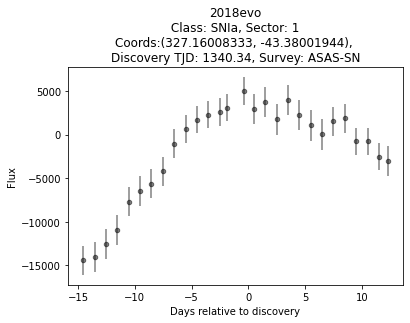

In [203]:
binned.plot.scatter(x="relative_time", y='unreddened_cts', c="00000", alpha=0.5, yerr=binned['unreddened_ects'], ylabel="Flux", xlabel="Days relative to discovery", title=plot_title)

# Find training labels
## 1. Max Light

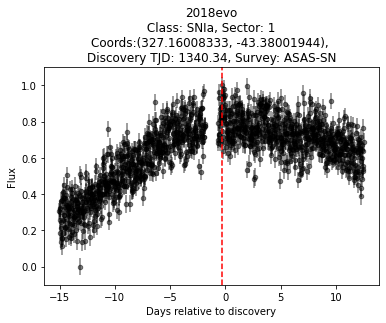

In [204]:
id_max = curve["normalized_cts"].idxmax()
max_data = curve.loc[id_max, :]
t_max = max_data['relative_time']

ax = display_curve('normalized_cts', 'normalized_ects')
ax.axvline(t_max, color="red", linestyle="--")

## 2. Explosion Time